In [4]:
# Importa bibliotecas
from unidecode import unidecode
import random
import requests

## Objetivo: desenvolver um algoritmo que joga o jogo da forca com apenas 5 chutes
Em um jogo da forca, onde se conhece todas as palavras disponíveis, é interessante a ideia de chutar a letra que possui uma frequência maior nas 
palavras. As frequências são 
baseadas no princípio de verificar qual a letra que mais aparece nas palavras. Como por exemplo, considere as palavras <i>abacate</i> e <i>mamao</i>, a letra <i>a</i> aparece nas duas palavras, por isso sua frequência é tida como <i>duas</i>, a letra <i>m</i> só aparece em mamao, por isso sua frequência é <i>uma</i>. Perceba que não consideramos a quantidade de letras em sí, mas apenas a quantidade de palavras que ela aparece. Isso é uma estratégia que visa minimizar a chance de errar a letra chutada, pois temos uma quantidade máxima de palavras que a possui no espaço amostral.

Essa técnica é boa pois no jogo da forca não perdemos vida se acertamos a letra. Assim, conseguimos reduzir cada vez mais o número de palavras no espaço  amostral, mesmo que de forma menos eficiente do que o método que conta o total bruto de letras nas palavras(por exemplo, em <i>abacate</i> e <i>mamao</i>, a contagem seria de que há 5 letras <i>a</i> e duas letras <i>m</i>). A gente pensou nesse método, mas vimos que existe um risco maior de errar a letra.

Isso pode ser demonstrado da seguinte forma: suponha que tenhamos um conjunto de n palavras no nosso espaço amostral <i>S</i>, vamos supor que a letra mais frequente (considerando a frequência das palavras contando apenas uma vez mesmo se a letra aparecer mais de uma vez na mesma palavra. Vamos chamar de método 1) seja a letra <i>a</i>, desse modo dentro do espaço amostral <i>S</i>, teremos um conjunto de k palavras, com k <= n. Suponha agora que estamos usando o método 2 (o que conta a letra mais de uma vez mesmo se ela aparece na mesma palavra) e que a letra mais frequente seja a letra b com uma quantidade de q  palavras que tem b, temos que q <= k. Vamos provar pelo método da prova por absurdo que q <= k.

Suponha, por hipótese, que temos <i>k</i> palavras com a letra <i>a</i> e sabemos que q > k. Mas se q > k, então existe q palavras com a letra b, ora, se existe q palavras com a letra b e q > k e o método 1 escolhe sempre a letra mais frequente(sem contar duas vezes), então chegamos na conclusão que k == q. Mas temos um absurdo, pois por hipótese, temos q > k. Logo, provamos que se q não é maior que k, q é menor ou igual a k. Assim, como q <= k, temos que no método 1, sempre vai haver mais palavras com a letra chutada, e no método 2 pode haver uma quantidade menor, pois ele se baseia não na quantidade de palavras que determinada letra aparece, mas sim na quantidade total de letras que aparece nas palavras. Logo, o método 2 consegue errar mais que o método que a gente escolheu.

A implementação segue abaixo:

Definimos uma classe JogoDeForca, que faz uma requisição pro site onde tem o banco de palavras. Essa clase possui um método de iniciar um novo jogo, no qual escolhe uma palavra aleatoriamente do grupo de palavras trazido do banco.

In [5]:
class JogoDeForca:
    def __init__(self):
        url = 'https://www.ime.usp.br/~pf/dicios/br-sem-acentos.txt'
        r = requests.get(url, allow_redirects=True)
        if r.status_code==200:
            # Cria uma lista com as palavras formatadas (minusculas e sem acento)
            self.content = str(r.content.decode()).split('\n')
            self.content = [unidecode(p.lower()).replace('ç', 'c') for p in self.content]
        else:
            print("Erro: ", r.status_code)
    
    def novo_jogo(self, vidas=5):
        self.vidas = vidas
        self.palavra = random.choice(self.content)
        return len(self.palavra)

Abaixo, temos a parte do algoritmo que realiza a escolha da letra que ele irá escolher para chutar. Letras restantes são todas as letras que o algoritmo ainda não chutou.
A lógica utillizada, como já comentado acima, foi ver qual letra está presente em uma quantidade maior de palavras.

In [6]:
def tentar_letra(lista_palavras, letras_restantes):
    # Dicionario com a frequencia de cada letra
    quantidade_letras = {}
    for palavra in lista_palavras:
        for letra in letras_restantes:
            # Incrementa na devida frequencia da letra se ela estiver nas palavras
            if letra in palavra:
                if letra in quantidade_letras:
                    quantidade_letras[f'{letra}'] += 1
                else:
                    quantidade_letras[f'{letra}'] = 1
    # Pega a letra com a maior frequência
    mais_recorrente = max(quantidade_letras.items(), key=lambda x: x[1])[0]
    return mais_recorrente
    

Aqui, estamos selecionando apenas as palavras que não possui a letra chutada, pra se no caso a letra chutada foi errada, ele remover do dicionário de palavras.

In [7]:
def remove_com_letra(letra, lista_palavras):
    sem_letra = []
    # Adiciona na lista de retorno apenas as palavras que não tiverem a letra
    for palavra in lista_palavras:
        if letra not in palavra:
            sem_letra.append(palavra)
    return sem_letra

Método que adiciona, se ele acertar, apenas as palavras que podem ser a palavra escolhida do jogo, pra isso, basta verificar se a letra chutada pelo algoritmo aparece na palavra escolhida e se sim, pegar todas as palavras do dicionário de palavras todas que possui aquela letra chutada na mesma posição em que aparece na letra escolhida.

In [8]:
def remove_sem_letra(resposta, letra, lista_palavras):
    com_letra = []

    # Encontra todos os indices onde há a letra na resposta
    indice = resposta.find(letra)
    ocorrencias = []
    while indice != -1:
        ocorrencias.append(indice)
        indice = resposta.find(letra, indice + 1)

    # # Adiciona na lista de retorno apenas as palavras que tiverem a letra nos mesmos indices da resposta
    for palavra in lista_palavras:
        corresponde = 0
        for indice in ocorrencias:
            if palavra[indice] == letra:
                corresponde += 1
        if corresponde == len(ocorrencias):
            com_letra.append(palavra)
            
                
    return com_letra

Função que já descarta as palavras que não tem o mesmo tamanho da palavra escolhida.

In [9]:
def remove_por_tamanho(tamanho, lista_palavras):
    lista_mesmos_tamanhos = []
    # Adiciona na lista de retorno apenas as palavras que tiverem o mesmo tamanho da resposta
    for palavra in lista_palavras:
        if len(palavra) == tamanho:
            lista_mesmos_tamanhos.append(palavra)
    return lista_mesmos_tamanhos

Função que verifica quantas vezes a letra chutada, se acertada, aparece na palavra escolhida, pra verificar quantas posições já temos preenchida na palavra, com o intuito de se já tivermos a quantidade de certas igual ao tamanho da palavra escolhida, então nosso algoritmo já sabe que acertou a palavra.

In [10]:
def calcula_certas(resposta, letra):
    certas = 0
    for l in resposta:
        if l == letra:
            certas += 1
    return certas

Abaixo, temos o algoritmo jogando,  ele começa com 5 vidas. 

In [13]:
def jogador(content, palavra, vidas):
    alfabeto = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    
    # Armazena apenas as palavras de mesmo tamanho que a resposta
    content = remove_por_tamanho(len(palavra), content)
    qtd_certas = 0

    # Chuta letras enquanto ainda possuir vida, senão chuta a palavra
    while vidas > 0:
        # Chuta uma letra com base nas palavras e letras do alfabeto ainda disponíveis
        letra = tentar_letra(content, alfabeto)
        # Se a letra estiver correta, remove as palavra que não a possuem ou que a possuem em posições erradas
        if letra in palavra:
            content = remove_sem_letra(palavra, letra, content)
            qtd_certas += calcula_certas(palavra, letra)
        # Se a letra estiver errada, remove as palavra que a possuem, além de perder uma vida
        else:
            content = remove_com_letra(letra, content)
            vidas -= 1
        # Remove das letras disponíveis aquela que foi chutada
        alfabeto.remove(letra)
        # Chuta se já tiver conhecimento de todas as letras
        if qtd_certas == len(palavra):
            return content[0], vidas
    return "Não sabe a palavra",vidas

Aqui, simulamos 100 jogos e verificamos em quantos jogos o algorimo consegue acertar a palavra em 5 ou menos tentativas. Podemos ver que ele acertou 99% das vezes.

In [18]:
certas = 0
erradas = 0

for _ in range(100):
    jogo = JogoDeForca()
    jogo.novo_jogo()
    chute = jogador(jogo.content, jogo.palavra, jogo.vidas)
    print(f"Palavra certa: {jogo.palavra}\nPalavra chutada: {chute[0]}\n")
    if jogo.palavra == chute[0]:
        certas += 1
    else:
        erradas +=1 
print(f"Certas: {certas}\nErradas: {erradas}")


Palavra certa: ardores
Palavra chutada: ardores

Palavra certa: espelhamento
Palavra chutada: espelhamento

Palavra certa: normalizaremo
Palavra chutada: normalizaremo

Palavra certa: duelariam
Palavra chutada: duelariam

Palavra certa: avariemo
Palavra chutada: avariemo

Palavra certa: soergue
Palavra chutada: soergue

Palavra certa: serenata
Palavra chutada: serenata

Palavra certa: desabaste
Palavra chutada: desabaste

Palavra certa: desembaracarieis
Palavra chutada: desembaracarieis

Palavra certa: ilustrarmo
Palavra chutada: ilustrarmo

Palavra certa: financieis
Palavra chutada: financieis

Palavra certa: indignastes
Palavra chutada: indignastes

Palavra certa: coroaremo
Palavra chutada: coroaremo

Palavra certa: exemplarieis
Palavra chutada: exemplarieis

Palavra certa: enderecarao
Palavra chutada: enderecarao

Palavra certa: desfalcam
Palavra chutada: desfalcam

Palavra certa: postergavamos
Palavra chutada: postergavamos

Palavra certa: estonteai
Palavra chutada: estonteai

Pala

abaixo, plotamos um gráfico de quantas ele acertou por número de vidas em 10000 jogos

In [25]:
certas = 0
erradas = 0
vidas = {"1": 0, "2": 0, "3": 0, "4": 0, "5": 0}
for _ in range(1000):
    jogo = JogoDeForca()
    jogo.novo_jogo()
    chute, vida = jogador(jogo.content, jogo.palavra, jogo.vidas)
    if vida > 0:
        vidas[str(vida)] += 1
        if jogo.palavra == chute:
            certas += 1
        else:
            erradas +=1 


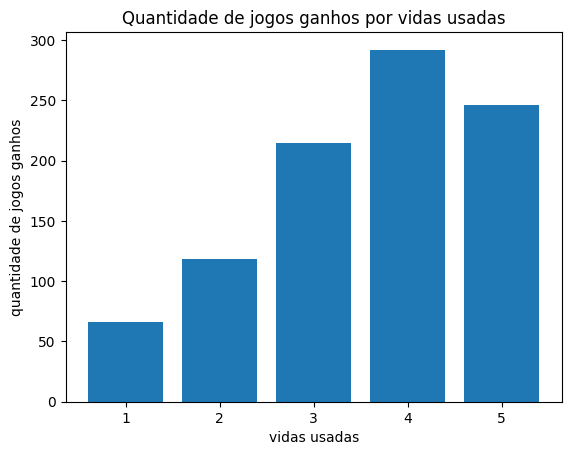

In [26]:
from matplotlib import pyplot as plt


plt.bar([int(i) for  i in vidas.keys()], vidas.values())
plt.xlabel("vidas usadas")
plt.title("Quantidade de jogos ganhos por vidas usadas")
plt.ylabel("quantidade de jogos ganhos")
plt.show()